In [6]:
import os
import sys
import json
from collections import Counter

import numpy as np
import pandas as pd

# from matplotlib.cm import get_cmap
import matplotlib
import matplotlib.pyplot as plt

from src.utils import set_based_accuracy, set_based_recall, set_based_precision

In [7]:
ae_maps = {
    map.split(",")[0]: map.split(",")[-1]
    for map in open("data/fin_mapping_nochargex.txt").read().strip().split("\n")
}
len(ae_maps), ae_maps

(217,
 {'[C;R;D3]': '[C;R]',
  '[C;R;D4]': '[C;R]',
  '[[C];R;D2]': '[C;R]',
  '[[C];R;D3]': '[C;R]',
  '[C;!R;D2]': '[C]',
  '[C;!R;D3]': '[C]',
  '[c;R;D3]': '[c]',
  '[C;!R;D4]': '[C]',
  '[[c];R;D2]': '[c]',
  '[[C];!R;D2]': '[C]',
  '[[C];!R;D1]': '[C]',
  '[[C];!R;D3]': '[C]',
  '[CH;R;D2]': '[CH;R]',
  '[CH;R;D3]': '[CH;R]',
  '[[CH]H;R;D2]': '[CH;R]',
  '[cH;R;D2]': '[cH]',
  '[CH;!R;D2]': '[CH]',
  '[CH;!R;D1]': '[CH]',
  '[CH;!R;D3]': '[CH]',
  '[[CH]H;!R;D1]': '[CH]',
  '[[CH]H;!R;D2]': '[CH]',
  '[CH2;R;D2]': '[CH2;R]',
  '[CH2;!R;D1]': '[CH2]',
  '[CH2;!R;D2]': '[CH2]',
  '[[CH2]H2;!R;D1]': '[CH2]',
  '[CH3;!R;D1]': '[CH3]',
  '[N;R;D2]': '[N;R]',
  '[N;R;D3]': '[N;R]',
  '[[N];R;D2]': '[N;R]',
  '[n;R;D2]': '[n]',
  '[N;!R;D2]': '[N]',
  '[n;R;D3]': '[n]',
  '[N;!R;D1]': '[N]',
  '[N;!R;D3]': '[N]',
  '[[N];!R;D1]': '[N]',
  '[[N];!R;D2]': '[N]',
  '[NH;R;D2]': '[NH;R]',
  '[NH;!R;D1]': '[NH]',
  '[[nH]H;R;D2]': '[nH]',
  '[NH;!R;D2]': '[NH]',
  '[[NH]H;!R;D1]': '[NH]',
 

In [8]:
file_path = 'data/db_search_rankings_30Apr2024.json'

original = json.load(open(file_path))
len(original)

5436

In [7]:
pred_all_accuracies = []
pred_all_recalls = []
pred_all_precisions = []
pred_mol_accuracies = []
pred_mol_recalls = []
pred_mol_precisions = []
for i, (testID, metadata) in enumerate(original.items()):

    src = metadata['src'] # raw src in trainset
    trg = metadata['trg'] # raw trg in trainset
    pred = metadata['pred'] # raw output from the model

    # metadata['pred_all'] = Counter(metadata['pred'].replace(' <mol> ', ' ').replace('.',' ').split())
    # metadata['pred_mol'] = metadata['pred'].split(' <mol> ')[-1].split()

    pred_all = metadata['pred_all'] # open frags, put in a set -> all RAE in predection 
    pred_mol = metadata['pred_mol'] # get only Mol_RAE section -> mol RAE in predection 
    mol_rae = [ae_maps.get(ae) for ae in metadata['nonIsomeric_AEs'] ]

    pred_all_accuracies.append(set_based_accuracy(pred_all, mol_rae))
    pred_mol_accuracies.append(set_based_accuracy(pred_mol, mol_rae))

    pred_all_recalls.append(set_based_recall(pred_all, mol_rae))
    pred_mol_recalls.append(set_based_recall(pred_mol, mol_rae))

    pred_all_precisions.append(set_based_precision(pred_all, mol_rae))
    pred_mol_precisions.append(set_based_precision(pred_mol, mol_rae))


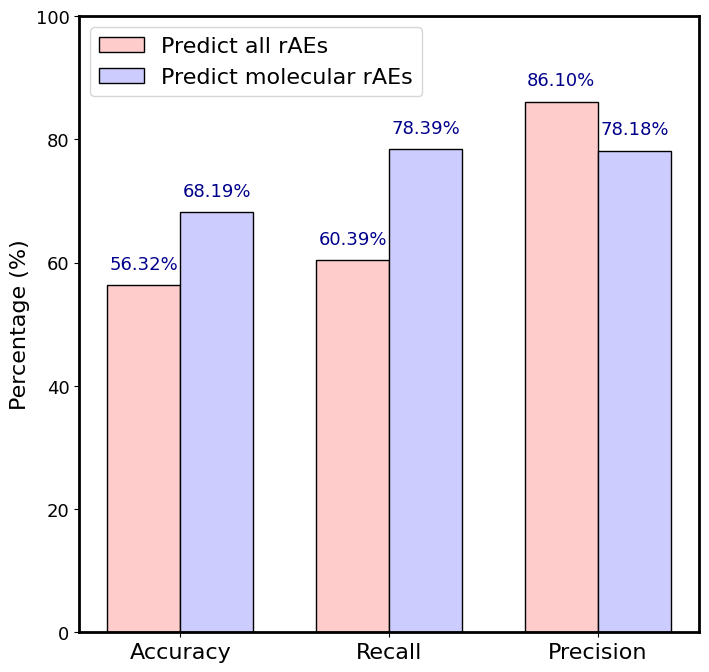

In [8]:
avg_metrics_dict = {
    'Pred All Accuracies': np.mean(pred_all_accuracies)*100,
    'Pred Mol Accuracies': np.mean(pred_mol_accuracies)*100,
    'Pred All Recalls': np.mean(pred_all_recalls)*100,
    'Pred Mol Recalls': np.mean(pred_mol_recalls)*100,
    'Pred All Precisions': np.mean(pred_all_precisions)*100,
    'Pred Mol Precisions': np.mean(pred_mol_precisions)*100,
}
labels = list(avg_metrics_dict.keys())
avg_metrics = list(avg_metrics_dict.values())

# Splitting the labels and values according to 'All' and 'Mol'
all_labels = [label for label in labels if 'All' in label]
mol_labels = [label for label in labels if 'Mol' in label]
all_values = [avg_metrics_dict[label] for label in all_labels]
mol_values = [avg_metrics_dict[label] for label in mol_labels]

fig, ax = plt.subplots(figsize=(8, 8))
index = np.arange(len(all_labels))
bar_width = 0.35

# Adjust the linewidth of the spines (frame lines)
ax.spines['top'].set_linewidth(2)    # Increase top spine linewidth
ax.spines['right'].set_linewidth(2)  # Increase right spine linewidth
ax.spines['left'].set_linewidth(2)   # Increase left spine linewidth
ax.spines['bottom'].set_linewidth(2) # Increase bottom spine linewidth


color_all = '#ffcccc'
color_mol = '#ccccff'

# Plotting bars with different colors for 'All' and 'Mol'
all_bars = ax.bar(index, all_values, bar_width, label='Predict all rAEs', color=color_all, edgecolor='black', linewidth=1)
mol_bars = ax.bar(index + bar_width, mol_values, bar_width, label='Predict molecular rAEs', color=color_mol, edgecolor='black', linewidth=1)

# Adding data labels
for bars, values in zip([all_bars, mol_bars], [all_values, mol_values]):
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, value+2, f'{value:.2f}%', ha='center', va='bottom', color='darkblue', fontsize=13)

ax.set_ylabel('Percentage (%)', fontsize=16)
ax.set_xticks(index + bar_width/2)
ax.set_xticklabels(['Accuracy', 'Recall', 'Precision'], fontsize=16, )
ax.tick_params(axis='y', labelsize=13)
plt.xticks(rotation=0, ha="center")
plt.ylim(0., 100)
ax.legend(loc='upper left', fontsize=16)
# fig.savefig('model_eval_.png', bbox_inches='tight', dpi=300)
plt.show()

In [4]:
import json
from collections import Counter

def compute_score(result_data, target='all'):

    result_score = {
        'True Positives': [],
        'True Negatives': [],
        'False Negatives': [],
        'False Positives': []
    }
    
    k_values = [1, 3, 5, 10]
    counts = {}
    
    for k in k_values:
        includeFalse = []
        excludeTrue = []
        includeTrue = []
        excludeFalse = []
    
        for metadata in result_data.values():
            src = metadata['src'] # raw src in trainset
            trg = metadata['trg'] # raw trg in trainset
            pred = metadata['pred'] # raw output from the model
        
            pred_all = metadata['pred_all'] # open frags, put in a set -> all RAE in predection 
            pred_mol = metadata['pred_mol'] # get only Mol_RAE section -> mol RAE in predection 
            
        
            gtruth = metadata['MsSearch_Rank']['GT']
            # unpacking
            gt_id, gt_smiles, gt_spectra, gt_rae, cos_score, tc_fp, tc_pred_all, tc_pred_mol, venn_diagrams = gtruth
            
            ranking = metadata['MsSearch_Rank']['Refs']
        
            for rank, entry in enumerate(ranking):
                if rank < k: #top-k 
                    venn = entry[-1][f'venn_{target}']  # venn_diagrams = {'venn_all': considering pred_all, 'venn_mol': considering pred_mol}
                    includeFalse.append(int(len(venn['only_pred_rae']) > 0))
                    excludeTrue.append(int(len(venn['only_ref_rae']) > 0))
                    includeTrue.append(int(len(venn['pred_gt_intersect']) > 0))
                    excludeFalse.append(int(len(venn['ref_gt_intersect']) > 0))
                    
        counts[k] = {'True Positives': Counter(includeTrue),
                  'True Negatives': Counter(excludeTrue),
                  'False Negatives': Counter(excludeFalse),
                  'False Positives': Counter(includeFalse)
                 }
        
        are_all_equal = len(set(map(len, [includeTrue, excludeTrue, includeFalse, excludeFalse]))) == 1
                
        if are_all_equal:
            size = len(includeTrue) 
            for key in result_score.keys():
                true_count = counts[k][key][1]
                result_score[key].append(round(true_count / size, 2))

    return result_score


# Load data
with open('data/db_search_rankings_30Apr2024.json') as f:
    original = json.load(f)
    
all_data = compute_score(original, target='all')
mol_data = compute_score(original, target='mol')
all_data, mol_data

({'True Positives': [0.5, 0.57, 0.61, 0.66],
  'True Negatives': [0.35, 0.42, 0.45, 0.49],
  'False Negatives': [0.3, 0.28, 0.26, 0.25],
  'False Positives': [0.97, 0.96, 0.96, 0.96]},
 {'True Positives': [0.42, 0.49, 0.54, 0.58],
  'True Negatives': [0.47, 0.55, 0.59, 0.63],
  'False Negatives': [0.44, 0.41, 0.4, 0.38],
  'False Positives': [0.52, 0.51, 0.51, 0.5]})

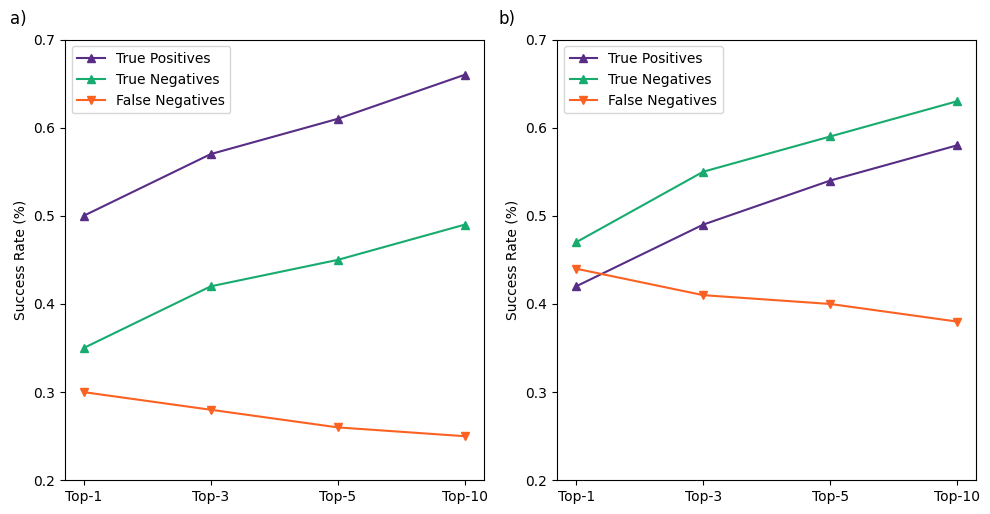

In [5]:
categories = ['Top-1', 'Top-3', 'Top-5', 'Top-10']

# Create plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes = axes.ravel()

#          In True    Ex True    Ex False  In False
colors = ['#572d86', '#17ab6f', '#FB6222', 'purple']
markers = ['^', '^', 'v', 'o']

for ax, data, title in zip(axes, [all_data, mol_data], ['For all', 'For mol']):
    for (label, values), color, marker in zip(data.items(), colors, markers):
        if label == 'False Positives': continue
        ax.plot(categories, values, marker=marker, label=label, color=color)
    # ax.set_title(title)
    ax.set_ylim(0.2, 0.7)
    ax.set_ylabel('Success Rate (%)')
    ax.legend() 

fig.text(0.02, 1.0, 'a)', ha='center', va='center', fontsize=12, weight='normal')
fig.text(0.509, 1.0, 'b)', ha='center', va='center', fontsize=12, weight='normal')

plt.tight_layout()
# fig.savefig('MsSearch_eval_metrics.png', bbox_inches='tight', dpi=300)
plt.show()